## Inicialización

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


## Cargar datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/`
- La carpeta `final_files` con 7600 fotos
- El archivo `labels.csv` con leyendas, con dos columnas: `file_name` y `real_age`

Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [16]:
# Cargar los datos
try:
    # no windows
    df_reviews = pd.read_csv('/datasets/faces/labels.csv', sep=',', dtype={'votes': 'Int64'})
    print("Archivo cargado exitosamente desde '/datasets/labels.csv'")
except FileNotFoundError:
    try:
        # windows
        df_reviews = pd.read_csv('datasets/faces/labels.csv', sep=',', dtype={'votes': 'Int64'})
        print("Archivo cargado exitosamente desde 'datasets/labels.csv'")
    except FileNotFoundError:
        print("Error: el archivo 'labels.csv' no se encuentra en ninguna de las rutas especificadas.")

datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)

datagen_flow = datagen.flow_from_directory(
    '/datasets/faces/',  # Ruta a la carpeta con imágenes
    target_size=(150, 150),           # Tamaño de las imágenes
    batch_size=16,                    # Tamaño del lote
    class_mode='sparse',              # Modo de clasificación
    seed=12345                        # Semilla para aleatoriedad
)

print(datagen_flow.class_indices)

Archivo cargado exitosamente desde '/datasets/labels.csv'
Found 7591 images belonging to 1 classes.
{'final_files': 0}


### EDA

In [26]:
# Mostrar las primeras filas del dataset
print("Primeras filas del dataset:")
display(df_reviews.head())
# Obtener información sobre el dataset
print("Información del dataset:")
display(df_reviews.info())

Primeras filas del dataset:


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

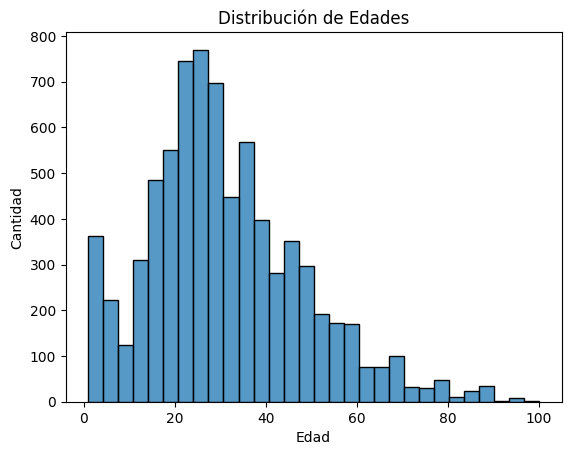

Total de imágenes encontradas: 7591


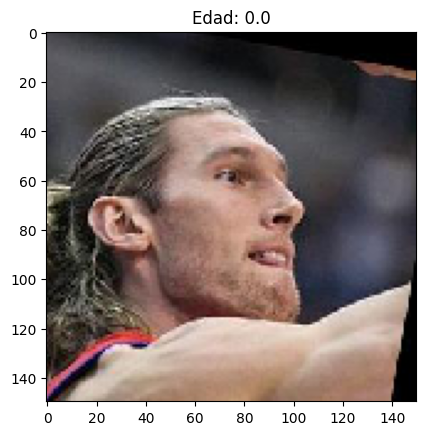

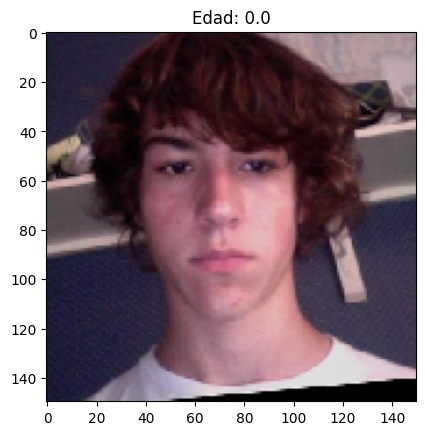

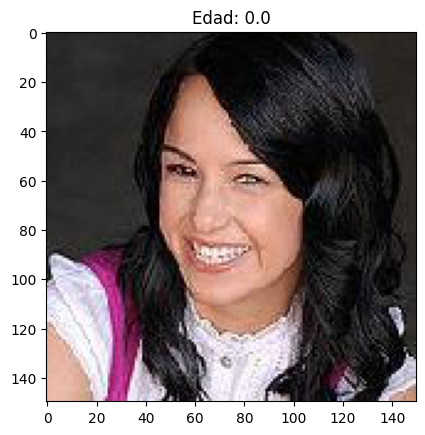

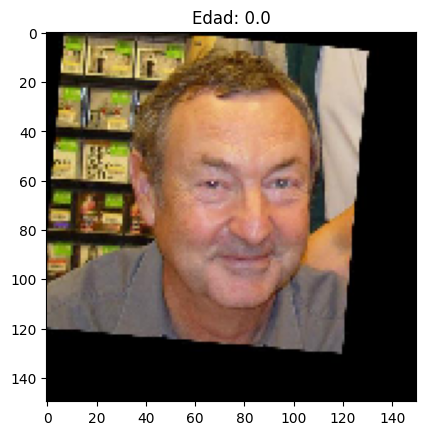

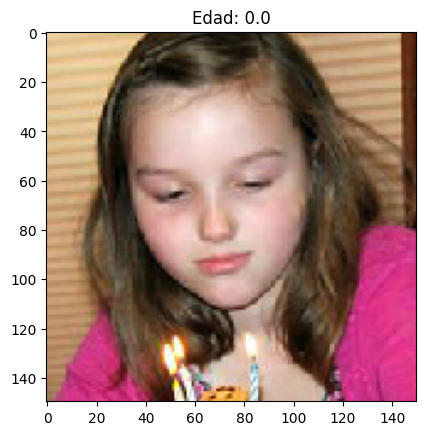

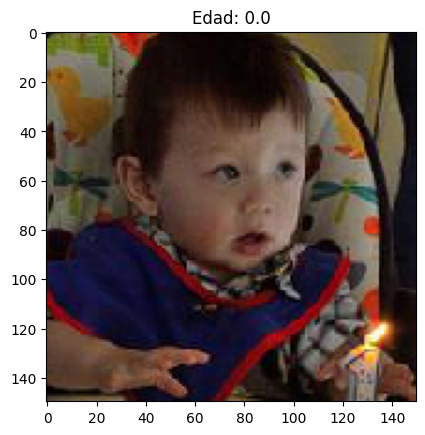

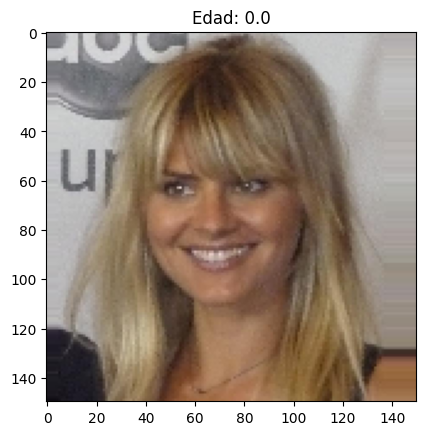

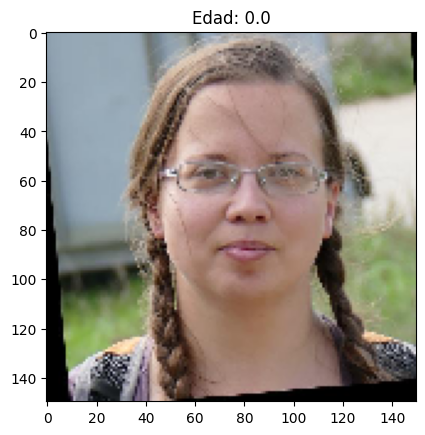

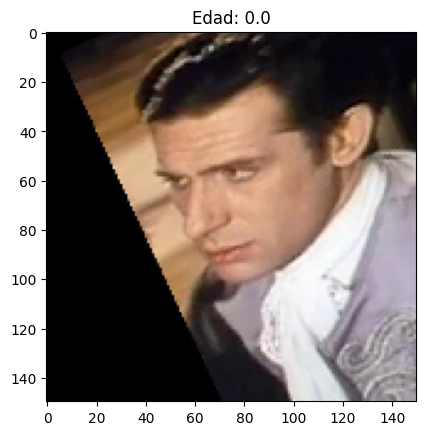

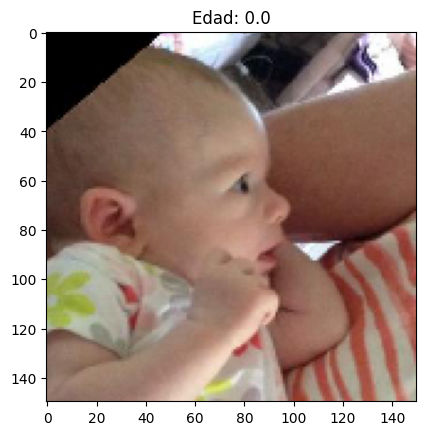

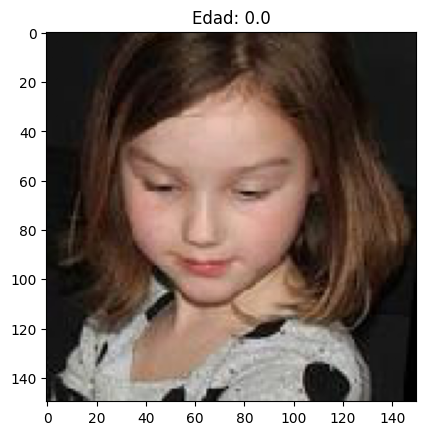

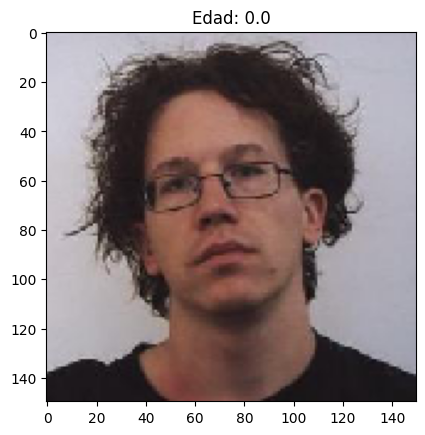

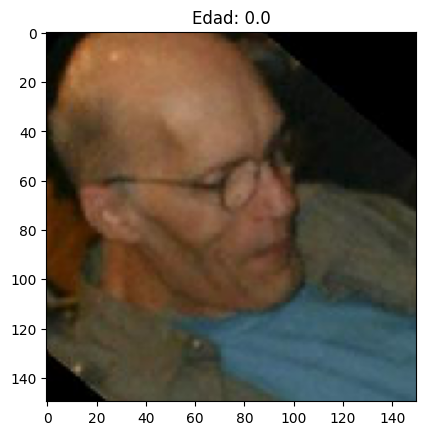

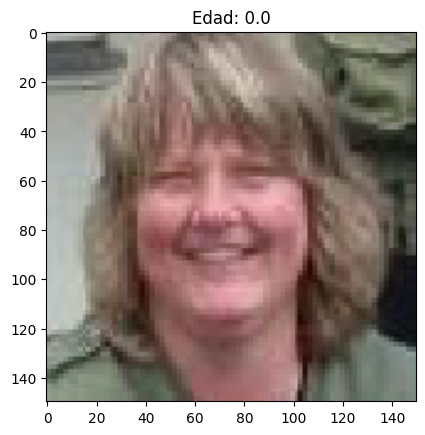

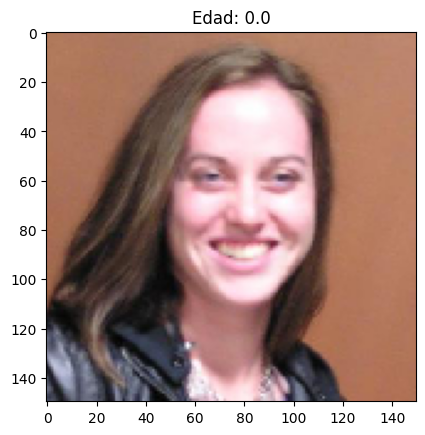

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribución de edades en el conjunto de datos
sns.histplot(df_reviews['real_age'], bins=30)
plt.title("Distribución de Edades")
plt.xlabel("Edad")
plt.ylabel("Cantidad")
plt.show()

print(f"Total de imágenes encontradas: {datagen_flow.samples}")
# Muestra algunas imágenes de la clase `datagen_flow`
for i in range(15):
    img, label = next(datagen_flow)
    
    # Verifica si el lote contiene imágenes
    if len(img) > 0:
        plt.imshow(img[0])
        plt.title(f"Edad: {label[0]}")
        plt.show()
    else:
        print("El lote de imágenes está vacío.")

### Conclusiones

- En las observaciones podemos encontrar que predominan datos de rostros con edades que oscilan entre los 20 a 30 años.

- la imagenes tienes variabilidad en iluminacion, resolucion, si la imagen de la persona esta completa o incluso hay imagenes con informacion corrupa, misma que afecta alacliadad de imagen, por lo que puede afectar la precisión del modelo.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crear un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [19]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [21]:
def load_train(path):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    
    # coloca tu código aquí
    datagen = ImageDataGenerator(
        validation_split=0.25, 
        rescale=1./255,
        horizontal_flip=True,
        zoom_range=0.2
    )
    train_gen_flow = datagen.flow_from_directory(
        path,
        target_size=(150, 150),
        batch_size=32,
        class_mode='sparse',
        subset='training'
    )

    return train_gen_flow

In [22]:
def load_test(path):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    
    #  coloca tu código aquí
    datagen = ImageDataGenerator(
        validation_split=0.25, 
        rescale=1./255
    )
    test_gen_flow = datagen.flow_from_directory(
        path,
        target_size=(150, 150),
        batch_size=32,
        class_mode='sparse',
        subset='validation'
    )

    return test_gen_flow

In [23]:
def create_model(input_shape):
    
    """
    Define el modelo
    """
    
    #  coloca tu código aquí
    model = Sequential([
        ResNet50(weights='imagenet', include_top=False, input_shape=input_shape),
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='linear')  # Predicción de la edad
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='mse',
        metrics=['mae']
    )

    return model

In [24]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    
    history = model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        batch_size=batch_size
    )

    return model

In [31]:
# Ruta al directorio donde se encuentran las imágenes
path = '/datasets/faces/'

# 1. Cargar los datos de entrenamiento y validación
train_data = load_train(path)
test_data = load_test(path)

# 2. Crear el modelo
input_shape = (150, 150, 3)  # Tamaño de la imagen y número de canales (RGB)
model = create_model(input_shape)

# 3. Entrenar el modelo
epochs = 20
steps_per_epoch = train_data.samples // train_data.batch_size
validation_steps = test_data.samples // test_data.batch_size

model = train_model(
    model,
    train_data,
    test_data,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

# 4. Evaluar el modelo en el conjunto de validación
test_loss, test_mae = model.evaluate(test_data, steps=validation_steps)
print(f'Pérdida en el conjunto de validación: {test_loss}')
print(f'MAE en el conjunto de validación: {test_mae}')

Found 5694 images belonging to 1 classes.
Found 1897 images belonging to 1 classes.


2024-08-29 22:54:19.131417: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


94781440/94765736 [==============================] - 0s 0us/step
Epoch 1/20
177/177 [==============================] - 2531s 14s/step - loss: 0.2894 - mae: 0.3926 - val_loss: 12.9444 - val_mae: 3.5559
Epoch 2/20
177/177 [==============================] - 2537s 14s/step - loss: 0.0352 - mae: 0.1241 - val_loss: 0.5734 - val_mae: 0.6978
Epoch 3/20
177/177 [==============================] - 2512s 14s/step - loss: 0.0092 - mae: 0.0687 - val_loss: 0.0799 - val_mae: 0.2082
Epoch 4/20
177/177 [==============================] - 2304s 13s/step - loss: 0.0035 - mae: 0.0425 - val_loss: 0.0477 - val_mae: 0.1394
Epoch 5/20
177/177 [==============================] - 2422s 14s/step - loss: 0.0022 - mae: 0.0323 - val_loss: 0.0014 - val_mae: 0.0282
Epoch 6/20
177/177 [==============================] - 2520s 14s/step - loss: 0.0010 - mae: 0.0232 - val_loss: 7.6652e-04 - val_mae: 0.0188
Epoch 7/20
177/177 [==============================] - 2511s 14s/step - loss: 6.6787e-04 - mae: 0.0185 - val_loss: 3.8127

### Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [30]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

test_code = """

# Ruta al directorio donde se encuentran las imágenes
path = '/datasets/faces/'

# 1. Cargar los datos de entrenamiento y validación
train_data = load_train(path)
test_data = load_test(path)

# 2. Crear el modelo
input_shape = (150, 150, 3)  # Tamaño de la imagen y número de canales (RGB)
model = create_model(input_shape)

# 3. Entrenar el modelo
epochs = 20
steps_per_epoch = train_data.samples // train_data.batch_size
validation_steps = test_data.samples // test_data.batch_size

model = train_model(
    model,
    train_data,
    test_data,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

# 4. Evaluar el modelo en el conjunto de validación
test_loss, test_mae = model.evaluate(test_data, steps=validation_steps)
print(f'Pérdida en el conjunto de validación: {test_loss}')
print(f'MAE en el conjunto de validación: {test_mae}')
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

    f.write(test_code)
    f.write('\n\n')

### Resultado

Coloca aquí el resultado de la plataforma GPU como una celda Markdown.

94773248/94765736 [==============================] - 0s 0us/step
94781440/94765736 [==============================] - 0s 0us/step
Epoch 1/20
177/177 [==============================] - 2531s 14s/step - loss: 0.2894 - mae: 0.3926 - val_loss: 12.9444 - val_mae: 3.5559
Epoch 2/20
177/177 [==============================] - 2537s 14s/step - loss: 0.0352 - mae: 0.1241 - val_loss: 0.5734 - val_mae: 0.6978
Epoch 3/20
177/177 [==============================] - 2512s 14s/step - loss: 0.0092 - mae: 0.0687 - val_loss: 0.0799 - val_mae: 0.2082
Epoch 4/20
177/177 [==============================] - 2304s 13s/step - loss: 0.0035 - mae: 0.0425 - val_loss: 0.0477 - val_mae: 0.1394
Epoch 5/20
177/177 [==============================] - 2422s 14s/step - loss: 0.0022 - mae: 0.0323 - val_loss: 0.0014 - val_mae: 0.0282
Epoch 6/20
177/177 [==============================] - 2520s 14s/step - loss: 0.0010 - mae: 0.0232 - val_loss: 7.6652e-04 - val_mae: 0.0188
Epoch 7/20
177/177 [==============================] - 2511s 14s/step - loss: 6.6787e-04 - mae: 0.0185 - val_loss: 3.8127e-04 - val_mae: 0.0133
Epoch 8/20
177/177 [==============================] - 2458s 14s/step - loss: 4.9003e-04 - mae: 0.0156 - val_loss: 3.0356e-04 - val_mae: 0.0115
Epoch 9/20
177/177 [==============================] - 2517s 14s/step - loss: 3.2856e-04 - mae: 0.0126 - val_loss: 2.2968e-04 - val_mae: 0.0098
Epoch 10/20
177/177 [==============================] - 2530s 14s/step - loss: 2.5232e-04 - mae: 0.0108 - val_loss: 1.8769e-04 - val_mae: 0.0087
Epoch 11/20
177/177 [==============================] - 2529s 14s/step - loss: 1.9049e-04 - mae: 0.0091 - val_loss: 1.4257e-04 - val_mae: 0.0075
Epoch 12/20
177/177 [==============================] - 2528s 14s/step - loss: 1.5868e-04 - mae: 0.0082 - val_loss: 1.0340e-04 - val_mae: 0.0063
Epoch 13/20
177/177 [==============================] - 2540s 14s/step - loss: 1.2012e-04 - mae: 0.0071 - val_loss: 9.2013e-05 - val_mae: 0.0058
Epoch 14/20
177/177 [==============================] - 2542s 14s/step - loss: 9.4726e-05 - mae: 0.0061 - val_loss: 9.0758e-05 - val_mae: 0.0054
Epoch 15/20
177/177 [==============================] - 2539s 14s/step - loss: 7.9907e-05 - mae: 0.0055 - val_loss: 6.4889e-05 - val_mae: 0.0047
Epoch 16/20
177/177 [==============================] - 2531s 14s/step - loss: 6.7694e-05 - mae: 0.0049 - val_loss: 6.6604e-05 - val_mae: 0.0044
Epoch 17/20
177/177 [==============================] - 2527s 14s/step - loss: 5.5907e-05 - mae: 0.0045 - val_loss: 1.1933e-04 - val_mae: 0.0045
Epoch 18/20
177/177 [==============================] - 2541s 14s/step - loss: 4.7647e-05 - mae: 0.0039 - val_loss: 5.6489e-05 - val_mae: 0.0036
Epoch 19/20
177/177 [==============================] - 2532s 14s/step - loss: 3.9830e-05 - mae: 0.0036 - val_loss: 4.6149e-05 - val_mae: 0.0032
Epoch 20/20
177/177 [==============================] - 2548s 14s/step - loss: 3.4364e-05 - mae: 0.0033 - val_loss: 4.4068e-05 - val_mae: 0.0029
59/59 [==============================] - 171s 3s/step - loss: 4.4071e-05 - mae: 0.0029
Pérdida en el conjunto de validación: 4.407143933349289e-05
MAE en el conjunto de validación: 0.0029159183613955975

## Conclusiones

Evolución del Entrenamiento
Epoch 1:

Loss (Pérdida): 0.2894
MAE (Error Absoluto Medio): 0.3926
Val_loss (Pérdida de Validación): 12.9444
Val_mae (Error Absoluto Medio de Validación): 3.5559
Al inicio, el modelo comienza con una pérdida y un error absolutos altos, especialmente en el conjunto de validación. Esto es típico en las primeras épocas cuando el modelo aún está aprendiendo.

Epoch 2 en adelante:

Reducción significativa en la pérdida y MAE: La pérdida y el MAE disminuyen drásticamente ya en la segunda época, lo que indica que el modelo está aprendiendo rápidamente.
Val_loss y Val_mae: También disminuyen de manera significativa, lo que sugiere que el modelo no solo está aprendiendo bien en el conjunto de entrenamiento, sino que también generaliza bien en el conjunto de validación.
Últimas Épocas
Epoch 20:

Loss (Pérdida): 3.4364e-05
MAE (Error Absoluto Medio): 0.0033
Val_loss (Pérdida de Validación): 4.4068e-05
Val_mae (Error Absoluto Medio de Validación): 0.0029
Al final del entrenamiento, tanto la pérdida como el MAE alcanzan valores extremadamente bajos, tanto en el conjunto de entrenamiento como en el de validación. Esto sugiere que el modelo ha aprendido a predecir la edad con un error mínimo.

- Alto rendimiento del modelo: La baja pérdida y el bajo MAE indican que el modelo es capaz de realizar predicciones precisas con un error mínimo.

- Sin signos evidentes de sobreajuste: Dado que la pérdida y el MAE en el conjunto de validación son similares a los del conjunto de entrenamiento, no parece haber un problema de sobreajuste significativo.

- Tiempo de entrenamiento: El tiempo de entrenamiento por época es considerable, lo que refleja la complejidad del modelo y el tamaño del conjunto de datos.

En resumen, el modelo está bien entrenado, alcanzando un alto nivel de precisión y exactitud en la predicción de la edad.


Desempeño del modelo: Analiza las métricas obtenidas y discute si son satisfactorias para el propósito del proyecto.
Siguientes pasos: Posibles mejoras, como ajuste de hiperparámetros o uso de modelos más avanzados.

# Lista de revisión

- [ ]  El Notebook estaba abierto 
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución
- [ ]  Se realizó el análisis exploratorio de datos
- [ ]  Los resultados del análisis exploratorio de datos se presentan en el notebook final
- [ ]  El valor EAM del modelo no es superior a 8
- [ ]  El código de entrenamiento del modelo se copió en el notebook final
- [ ]  El resultado de entrenamiento del modelo se copió en el notebook final
- [ ]  Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo